##  Assignment 10 : 
Submitted by : 2018201051<br>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [2]:
df = pd.read_csv('GoogleStocks.csv')
df = df.sort_values('date')
df.head()

date     close        volume      open       high       low
0         15:07  1,169.41     1,037,784  1,185.50  1,187.559  1,159.37
755  2016/03/28  733.5300  1300817.0000  736.7900   738.9900  732.5000
754  2016/03/29  744.7700  1902254.0000  734.5900   747.2500  728.7600
753  2016/03/30  750.5300  1782278.0000  750.1000   757.8800  748.7400
752  2016/03/31  744.9500  1718638.0000  749.2500   750.8500  740.9400

In [3]:
df = df.drop(df.index[0])
df[["close", "volume" , "open" , "high" , "low"]] = df[["close", "volume" , "open" , "high" , "low"]].apply(pd.to_numeric)
df['avg'] = (df['low'] + df['high'])/2
df = df.reset_index(drop = True)
print(df.shape)
df.head()

(755, 7)


date   close     volume    open    high     low      avg
0  2016/03/28  733.53  1300817.0  736.79  738.99  732.50  735.745
1  2016/03/29  744.77  1902254.0  734.59  747.25  728.76  738.005
2  2016/03/30  750.53  1782278.0  750.10  757.88  748.74  753.310
3  2016/03/31  744.95  1718638.0  749.25  750.85  740.94  745.895
4  2016/04/01  749.91  1576240.0  738.60  750.34  737.00  743.670

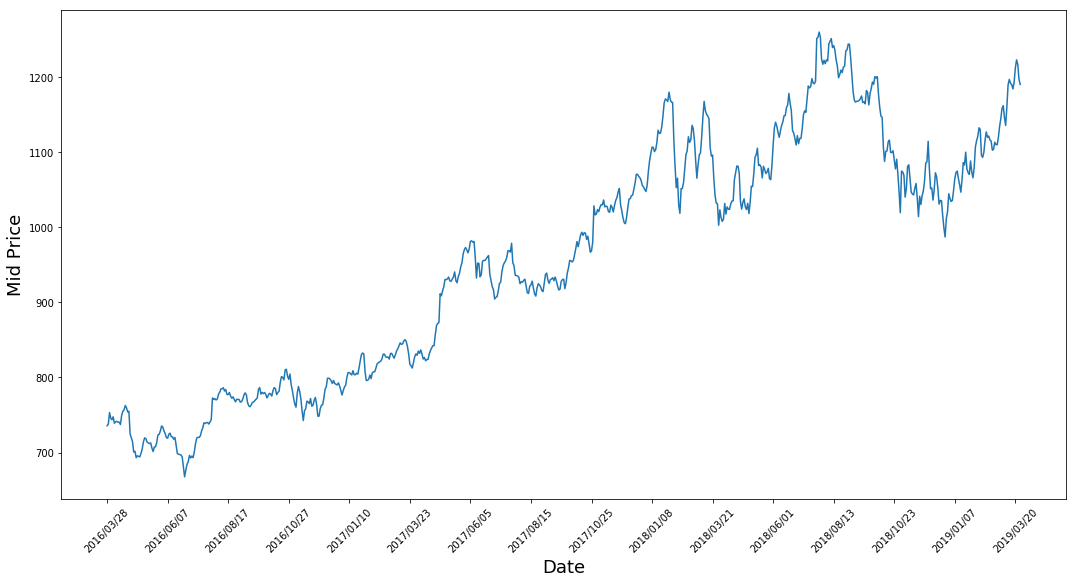

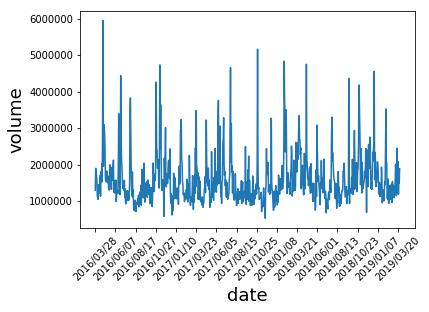

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['avg']))
# plt.plot(range(df.shape[0]),(df['low']) , color =  'red')
# plt.plot(range(df.shape[0]),(df['high']) , color = 'green')
# plt.plot(range(df.shape[0]),(df['open']) , color = 'blue')
# plt.plot(range(df.shape[0]),(df['close']), color = 'black')

plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

plt.plot(range(df.shape[0]),(df['volume']))
plt.xticks(range(0,df.shape[0],50),df['date'].loc[::50],rotation=45)
plt.xlabel('date',fontsize=18)
plt.ylabel('volume',fontsize=18)
plt.show()

In [4]:
train_df = df.iloc[: 550, [2,6]]
val_df = df.iloc[550: , [2,6]]
print(train_df.shape)
print(val_df.shape)
train_df.head()

(550, 2)
(205, 2)


volume      avg
0  1300817.0  735.745
1  1902254.0  738.005
2  1782278.0  753.310
3  1718638.0  745.895
4  1576240.0  743.670

Due to the observation you made earlier, that is, different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 125.



In [5]:
# Train the Scaler with training data and smooth data
train_data = train_df.as_matrix()
scaler = MinMaxScaler()
smoothing_window_size = 125
for i in range(0,train_data.shape[0],smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [7]:
print(train_data)

[[0.11125126 0.57311416]
 [0.22623082 0.59217495]
 [0.20329444 0.721257  ]
 ...
 [0.27570666 0.60354164]
 [0.09321231 0.591102  ]
 [0.5828989  0.77994048]]


In [6]:
val_data = val_df.as_matrix() 
val_data = scaler.transform(val_data)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


###  Standard Averaging : 

$$ x_{t+1} = 1/N \sum_{i = t-N}^{t} x_i $$

In other words, you say the prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N.

In [9]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(550):
    EMA = gamma*train_data[ti,1] + (1-gamma)*EMA
    train_data[ti,1] = EMA

# Used for visualization and test purposes
all_data = np.concatenate([train_data,val_data],axis=0)

In [10]:
window_size = 20
N = len(train_data)
print(N)
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

550
MSE error for standard averaging: 0.02780


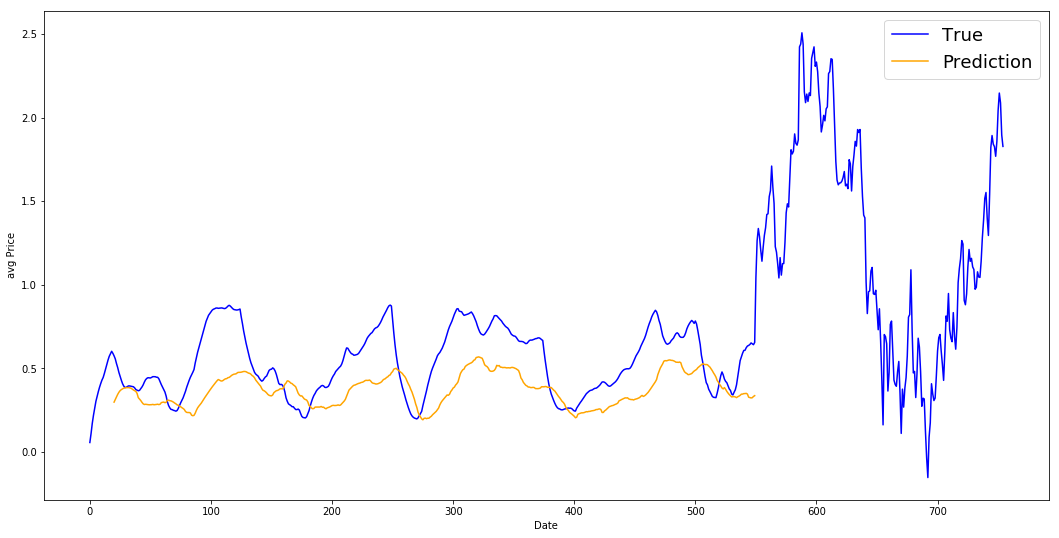

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), all_data[:,1],color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

###  Eponential  Moving Average : 

In the exponential moving average method, you calculate$ x_{t+1} $ as,

$$ x_{t+1} = EMA_t = γ × EMA_{t-1} + (1-γ) x_t $$ where$ EMA_0$ = 0 and EMA is the exponential moving average value you maintain over time.


In [12]:
window_size = 20
N = len(train_data)
run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1 ,1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx, 1])**2)
    run_avg_x.append(date)
print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00063


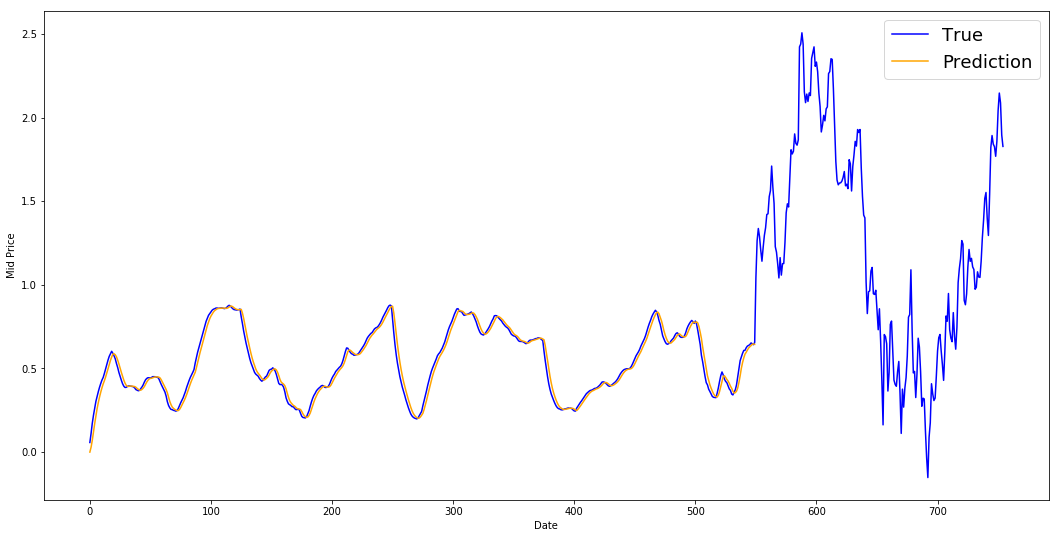

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_data[:,1],color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

####  Where EMA goes wrong ?

try to make predictions in windows (say you predict the next 2 days window, instead of just the next day)<br>
some solutions : Momentum based algorithm(considers volume field)


## Recurrent Neural Network based prediction  :  

In [8]:
def normalize_data(data):
    min_max_scaler = MinMaxScaler()
    data[: , :] = min_max_scaler.fit_transform(data[: , :])
    return data  

In [9]:
data = df.iloc[: , [2,6]]
data = data.as_matrix()
data = normalize_data(data)
print(data.shape)
time_step = 20

(755, 2)


/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [6]:
class rnn(object) :
    def __init__(self, layers , nodes , time_step , epochs = 100):
        self.layers = layers
        self.nodes = nodes
        self.time_step = time_step
        self.epochs = epochs
        self.history = None
        
    def data_process(self,  data):
        X,Y = [],[]
        for i in range(len(data)-self.time_step-1):
            X.append(data[i:(i + self.time_step),:])
            Y.append(data[(i+self.time_step),-1])
        return np.array(X),np.array(Y)
        
    def fit_and_predict(self , data):
        X,y = self.data_process(data)
        X_train,X_test = X[:int(X.shape[0]*0.80) , :],X[int(X.shape[0]*0.80):, :]
        y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
        
        model = Sequential()
        model.add(LSTM(self.nodes, return_sequences=True,input_shape=(self.time_step, X_train.shape[-1])))
        
        for i in range(self.layers-2) :
            model.add(LSTM(self.nodes, return_sequences=True))
        model.add(LSTM(self.nodes))
        model.add(Dense(1 , activation =  'relu'))
        model.compile(optimizer='adam',loss='mse')

        self.history = model.fit(X_train,y_train,epochs=self.epochs,validation_data=(X_test,y_test),shuffle=False)
        
        Xt = model.predict(X_test)
        plt.plot(y_test.reshape(-1,1))
        plt.plot(Xt)
        
        #input data shape: (batch_size, timesteps, data_dim)

        

### 1. hidden layers = 2 , cells  = 30  , time_steps = 20

Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 6s 11ms/step - loss: 0.0237 - val_loss: 0.0470
Epoch 2/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0530 - val_loss: 0.0199
Epoch 3/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 4/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 5/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 7/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 8/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 9/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/50
587/587 [==============================] 

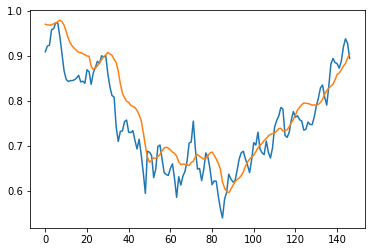

In [48]:
rnn1 = rnn(2, 30, 20,50)
rnn1.fit_and_predict(data)

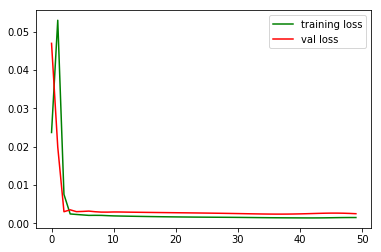

In [49]:
plt.plot(rnn1.history.history['loss'] , color = 'green')
plt.plot(rnn1.history.history['val_loss']  , color = 'red')
plt.legend(['training loss' , 'val loss'])

### 2. hidden layers = 2 , cells  = 30  , time_steps = 50

Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 8s 14ms/step - loss: 0.0119 - val_loss: 0.0064
Epoch 2/50
563/563 [==============================] - 1s 2ms/step - loss: 0.0233 - val_loss: 0.0074
Epoch 3/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.0084
Epoch 4/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 5/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0062
Epoch 6/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 8/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 9/50
563/563 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 10/50
563/563 [==============================] 

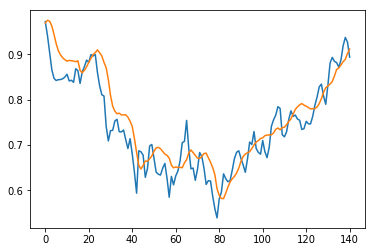

In [50]:
rnn2 = rnn(2, 30, 50, 50)
rnn2.fit_and_predict(data)

### 3. hidden layers = 2 , cells  = 30  , time_steps = 75

Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 9s 17ms/step - loss: 0.0255 - val_loss: 0.0095
Epoch 2/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0287 - val_loss: 0.0052
Epoch 3/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0180 - val_loss: 0.0077
Epoch 4/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 5/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 6/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 7/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 8/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 9/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 10/50
543/543 [==============================] 

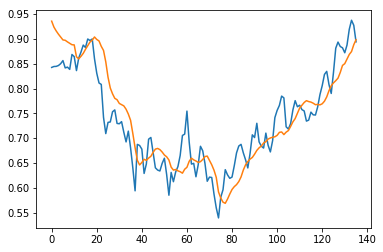

In [52]:
rnn3 = rnn(2, 30, 75 , 50)
rnn3.fit_and_predict(data)

### 4. hidden layers = 2 , cells  = 50  , time_steps = 20

Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 8s 14ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 2/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0263 - val_loss: 0.0267
Epoch 3/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 4/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 5/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 6/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 8/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 9/50
587/587 [==============================] - 1s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 10/50
587/587 [==============================] 

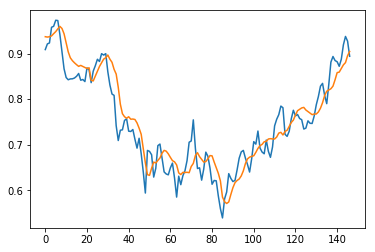

In [53]:
rnn4 = rnn(2, 50, 20 , 50)
rnn4.fit_and_predict(data)

### 5. hidden layers = 2 , cells  = 50  , time_steps = 50

Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 11s 20ms/step - loss: 0.0090 - val_loss: 0.0128
Epoch 2/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0233 - val_loss: 0.0260
Epoch 3/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 4/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 5/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 9/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/50
563/563 [==============================]

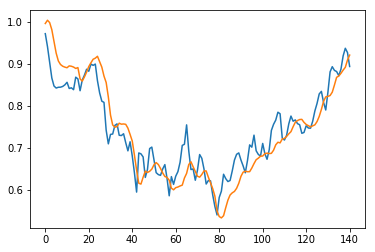

In [58]:
rnn5 = rnn(2, 50, 50 , 50)
rnn5.fit_and_predict(data)

### 6. hidden layers = 2 , cells  = 50  , time_steps = 75

Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 10s 19ms/step - loss: 0.0146 - val_loss: 0.0072
Epoch 2/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0218 - val_loss: 0.0135
Epoch 3/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0118 - val_loss: 0.0037
Epoch 4/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0069 - val_loss: 0.0109
Epoch 5/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/50
543/543 [==============================] - 2s 4ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 7/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/50
543/543 [==============================] - 4s 6ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 9/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 10/50
543/543 [==============================]

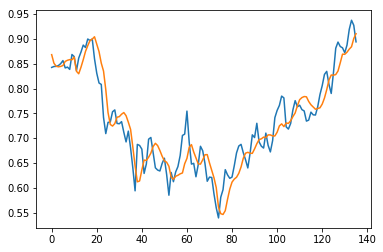

In [55]:
rnn6 = rnn(2, 50, 75 , 50)
rnn6.fit_and_predict(data)

### 7. hidden layers = 2 , cells  = 80  , time_steps = 20

Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 11s 19ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 2/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0180 - val_loss: 0.0028
Epoch 3/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0178
Epoch 4/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0198
Epoch 5/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 6/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 7/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0029
Epoch 8/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0052
Epoch 9/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 10/50
587/587 [==============================]

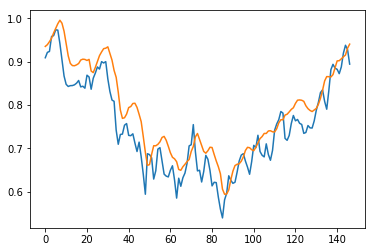

In [60]:
rnn7 = rnn(2, 80, 20 , 50)
rnn7.fit_and_predict(data)

### 8. hidden layers = 2 , cells  = 80  , time_steps = 50

Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 13s 24ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 2/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0199 - val_loss: 0.0106
Epoch 3/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0072 - val_loss: 0.0178
Epoch 4/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 5/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 6/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 7/50
563/563 [==============================] - 2s 3ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 8/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 9/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 10/50
563/563 [==============================]

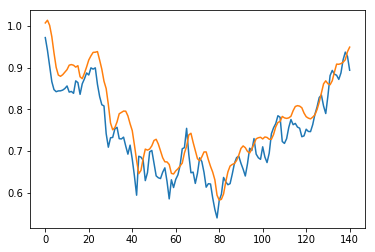

In [61]:
rnn8 = rnn(2, 80, 50 , 50)
rnn8.fit_and_predict(data)

### 9. hidden layers = 2 , cells  = 80  , time_steps = 75

Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 14s 25ms/step - loss: 0.0119 - val_loss: 0.0053
Epoch 2/50
543/543 [==============================] - 2s 5ms/step - loss: 0.0115 - val_loss: 0.0039
Epoch 3/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0063 - val_loss: 0.0150
Epoch 4/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0082 - val_loss: 0.0138
Epoch 5/50
543/543 [==============================] - 2s 5ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 6/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 7/50
543/543 [==============================] - 2s 5ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 8/50
543/543 [==============================] - 2s 5ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 9/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 10/50
543/543 [==============================]

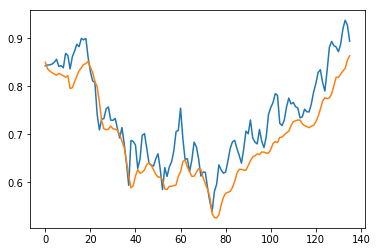

In [62]:
rnn9 = rnn(2, 80, 75 , 50)
rnn9.fit_and_predict(data)

### 10 . hidden layers = 3 , cells  = 30  , time_steps = 20


Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 14s 23ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 2/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0440 - val_loss: 0.0088
Epoch 3/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0052
Epoch 4/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0081 - val_loss: 0.0150
Epoch 5/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 6/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0105
Epoch 7/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 8/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 9/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 10/50
587/587 [==============================]

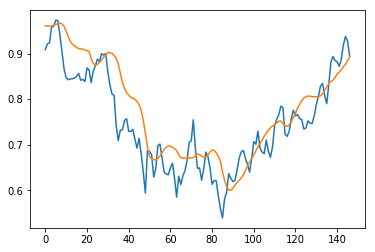

In [63]:
rnn10 = rnn(3, 30, 20,50)
rnn10.fit_and_predict(data)

### 11. hidden layers = 3 , cells  = 30  , time_steps = 50


Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 16s 28ms/step - loss: 0.0093 - val_loss: 0.0192
Epoch 2/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0638 - val_loss: 0.0071
Epoch 3/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0384 - val_loss: 0.0099
Epoch 4/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 5/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 6/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 7/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 8/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 9/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 10/50
563/563 [==============================]

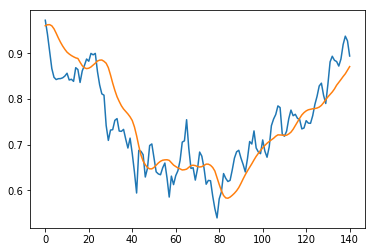

In [65]:
rnn11 = rnn(3, 30,50 ,50)
rnn11.fit_and_predict(data)

### 12 . hidden layers = 3 , cells  = 30  , time_steps = 75

Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 17s 32ms/step - loss: 0.0102 - val_loss: 0.0077
Epoch 2/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0359 - val_loss: 0.0065
Epoch 3/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0263 - val_loss: 0.0083
Epoch 4/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 5/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 6/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 7/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 8/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 9/50
543/543 [==============================] - 3s 5ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 10/50
543/543 [==============================]

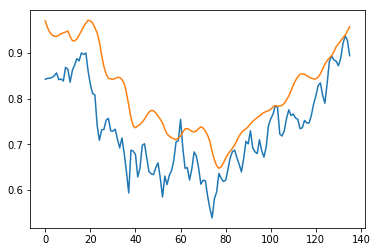

In [66]:
rnn12 = rnn(3, 30 ,  75 ,50)
rnn12.fit_and_predict(data)

### 13 . hidden layers = 3 , cells  = 50  , time_steps = 20


Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 18s 31ms/step - loss: 0.0089 - val_loss: 0.0138
Epoch 2/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0369 - val_loss: 0.0427
Epoch 3/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0181
Epoch 4/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 5/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0053
Epoch 6/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0083
Epoch 7/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 8/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 10/50
587/587 [==============================]

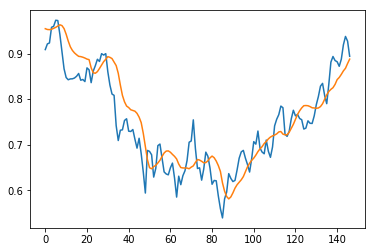

In [69]:
rnn13 = rnn(3, 50 , 20 ,50)
rnn13.fit_and_predict(data)

### 14 . hidden layers = 3 , cells  = 50  , time_steps = 50


Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 19s 34ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 2/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0283 - val_loss: 0.0473
Epoch 3/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0149 - val_loss: 0.0290
Epoch 4/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0072 - val_loss: 0.0110
Epoch 5/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0133 - val_loss: 0.0039
Epoch 6/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0130 - val_loss: 0.0062
Epoch 7/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 8/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 9/50
563/563 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 10/50
563/563 [==============================]

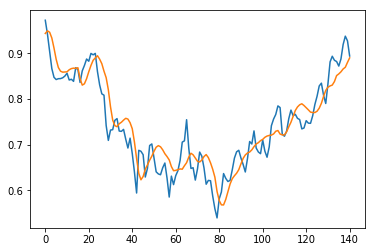

In [70]:
rnn14 = rnn(3, 50 , 50 ,50)
rnn14.fit_and_predict(data)

### 15 . hidden layers = 3 , cells  = 50  , time_steps = 75


Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 21s 38ms/step - loss: 0.0145 - val_loss: 0.0596
Epoch 2/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0594 - val_loss: 0.0105
Epoch 3/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0362 - val_loss: 0.0097
Epoch 4/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0108 - val_loss: 0.0180
Epoch 5/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 6/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0064
Epoch 7/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 8/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 9/50
543/543 [==============================] - 3s 6ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 10/50
543/543 [==============================]

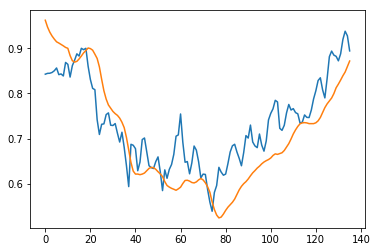

In [71]:
rnn15 = rnn(3, 50 , 75 ,50)
rnn15.fit_and_predict(data)

### 16 . hidden layers = 3 , cells  = 80  , time_steps = 20


Train on 587 samples, validate on 147 samples
Epoch 1/50
587/587 [==============================] - 20s 34ms/step - loss: 0.0124 - val_loss: 0.0074
Epoch 2/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0261 - val_loss: 0.0035
Epoch 3/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 4/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0338
Epoch 5/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0173
Epoch 6/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 7/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 8/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0202 - val_loss: 0.0037
Epoch 9/50
587/587 [==============================] - 1s 2ms/step - loss: 0.0250 - val_loss: 0.0051
Epoch 10/50
587/587 [==============================]

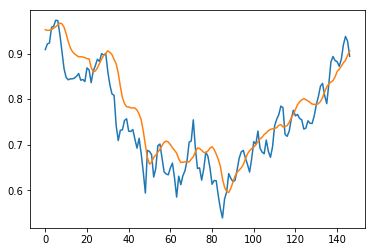

In [73]:
rnn16 = rnn(3 , 80 , 20 ,50)
rnn16.fit_and_predict(data)

### 17 . hidden layers = 3 , cells  = 80  , time_steps = 50


Train on 563 samples, validate on 141 samples
Epoch 1/50
 96/563 [====>.........................] - ETA: 2:02 - loss: 0.0112

/home/archit/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231848). Check your callbacks.
  % delta_t_median)


563/563 [==============================] - 35s 62ms/step - loss: 0.0120 - val_loss: 0.0061
Epoch 2/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0214 - val_loss: 0.0037
Epoch 3/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 4/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0085 - val_loss: 0.0136
Epoch 5/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0059 - val_loss: 0.0114
Epoch 6/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0099
Epoch 7/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0133
Epoch 8/50
563/563 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0161
Epoch 9/50
563/563 [==============================] - 3s 4ms/step - loss: 0.0103 - val_loss: 0.0147
Epoch 10/50
563/563 [==============================] - 3s 4ms/step - loss: 0.0156 - val_loss: 0.0102
Epoch 11

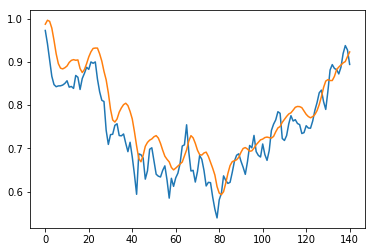

In [74]:
rnn17 = rnn(3 , 80 , 50 ,50)
rnn17.fit_and_predict(data)

### 18 . hidden layers = 3 , cells  = 80  , time_steps = 75


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 543 samples, validate on 136 samples
Epoch 1/50
543/543 [==============================] - 9s 17ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 2/50
543/543 [==============================] - 5s 10ms/step - loss: 0.0192 - val_loss: 0.0042
Epoch 3/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 4/50
543/543 [==============================] - 4s 8ms/step - loss: 0.0100 - val_loss: 0.0177
Epoch 5/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0072 - val_loss: 0.0147
Epoch 6/50
543/543 [==============================] - 5s 10ms/step - loss: 0.0038 - val_loss: 0.0111
Epoch 7/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0053 - val_loss: 0.0140
Epoch 8/50
543/543 [==============================] - 5s 9ms/step - loss: 0.0105 - val_loss: 0.0182
Epoch 9/50
543/543 [===========

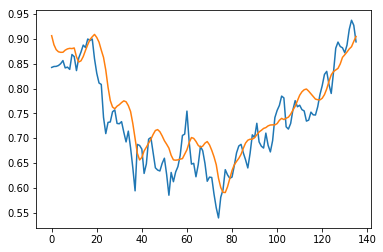

In [7]:
rnn18 = rnn(3 , 80 , 75 ,50)
rnn18.fit_and_predict(data)

###  HMM based prediction : 

In [116]:
from hmmlearn.hmm import GaussianHMM
from hmmlearn.hmm import MultinomialHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import math
import warnings
warnings.filterwarnings('ignore')

##  Question 2 : 

In [120]:
 
states = ('E', '5' , 'I' )
 
observations = ('A' , 'C' , 'G' , 'T')
 
start_probability = {'E': 1, '5': 0 ,'I' : 0}
end_probability = {'E': 0, '5': 0 ,'I' : 0.1}
 
transition_probability = {
   'E' : {'E': 0.9, '5': 0.1 , 'I' : 0},
   '5' : {'E': 0, '5': 0 , 'I' :1 },
   'I' : {'E': 0, '5': 0 , 'I' : 0.9}
    }
 
emission_probability = {
   'E' : {'A': 0.25, 'C': 0.25, 'G': 0.25,  'T' : 0.25},
   '5' : {'A': 0.05, 'C': 0, 'G': 0.95,  'T' :0 },
   'I' : {'A': 0.4, 'C': 0.1, 'G': 0.1,  'T' :0.4}
    }

model = MultinomialHMM(n_components=3)
model.startprob_ = np.array([1,0,0])
model.endprob_ = np.array([0,0,0.1])

model.transmat_ = np.array([[0.9, 0.1, 0],
                            [0, 0, 1] ,
                            [0, 0, 1]])
model.emissionprob_ = np.array([[0.25, 0.25, 0.25, 0.25],
                                [0.05, 0, 0.95,  0] , 
                               [0.4, 0.1 ,0.1 , 0.4]])


In [121]:
#"CTTCATGTGAAAGCAGACGTAAGTCA" A = 0 , C = 1 , G = 2 , T = 3
sequence = [1,3,3,1,0,3,2,3,2,0,0,0,2,1,0,2,0,1,2,3,0,0,2,3,1,0]

logprob, seq = model.decode(np.array([sequence]).transpose())
print(logprob)
print(seq)
# E = 0 ,  5 = 1 , I = 2
print("following sequence correspond to :")
print("EEEEEEEEEEEEEEEEEE5IIIIIII")

-38.284929499081535
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
following sequence correspond to :
EEEEEEEEEEEEEEEEEE5IIIIIII


##  Question 1.2  : HMM 
#### based on the following paper : 
https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=SILC2016&paper_id=38

In [90]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [145]:
class HMM(object):
    def __init__(self , states , time_step):
        self.states = states
        self.time_step = time_step
        self.num_calib = 100

    def fit_and_predict(self, dataset):
        
        predicted_stock_data = np.empty([0,dataset.shape[1]])

        for idx in range(self.num_calib):
            train_dataset = dataset[idx : idx + self.time_step:]
            test_data = dataset[idx + self.time_step,:] 
            if idx == 0:
#                 n_components=4, covariance_type="diag", n_iter=100
                model = GaussianHMM(n_components=self.states, covariance_type='full',verbose = True,  n_iter=100, init_params='stmc')
            else:
                # Retune the model by using the HMM paramters from the previous iterations as the prior
                model = GaussianHMM(n_components=self.states, covariance_type='full',verbose = True, n_iter=100, init_params='')
                model.transmat_ = transmat_retune_prior 
                model.startprob_ = startprob_retune_prior
                model.means_ = means_retune_prior
                model.covars_ = covars_retune_prior

            model.fit(train_dataset)
            
            print(model.transmat_)
            
            transmat_retune_prior = model.transmat_
            startprob_retune_prior = model.startprob_
            means_retune_prior = model.means_
            covars_retune_prior = model.covars_

            if model.monitor_.iter == 100:
                print('Increase number of iterations')
                sys.exit(1)

            iters = 1;
            past_likelihood = []
            K = self.time_step
            curr_likelihood = model.score(train_dataset[0:K , :])
            num_examples = train_dataset.shape[0]
            
            iters = num_examples
            
            while iters > 0 :
                past_likelihood = np.append(past_likelihood, model.score(train_dataset[0:iters, :]))
                iters = iters - 1

            
            likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
            
            predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
            
            predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + self.time_step-1,:] + predicted_change))
            
            mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
            print('MAPE is ',mape)
            print(predicted_stock_data)
#             plt.plot(range(100), predicted_stock_data);
#             plt.title('Predicted stock prices')
#             plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
#             plt.xlabel('Time steps')
#             plt.ylabel('Price')
#             plt.figure()
#             plt.plot(range(100),dataset[range(100),:])
#             plt.title('Actual stock prices')
#             plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
#             plt.xlabel('Time steps')
#             plt.ylabel('Price')

        

In [146]:
data_new = data[:,0]
hmm1 = HMM(4,20)
hmm1.fit_and_predict(data_new.reshape(-1,  1))

[[4.98083606e-01 2.02120787e-33 4.46980423e-01 5.49359710e-02]
 [1.75316033e-47 1.00000000e+00 1.48032300e-47 2.49575353e-44]
 [4.98976156e-01 1.32665743e-29 4.44754589e-01 5.62692554e-02]
 [4.18699942e-06 9.99992025e-01 3.78492802e-06 2.68416691e-09]]
MAPE is  [4.69783761]
[[0.88888417]]
[[5.02445051e-01 7.44599744e-39 4.40128311e-01 5.74266382e-02]
 [9.12311535e-35 1.00000000e+00 8.77314078e-35 2.82901682e-33]
 [5.02434959e-01 1.31145239e-34 4.36885528e-01 6.06795136e-02]
 [1.31263228e-07 9.99999734e-01 1.34641408e-07 5.25559561e-12]]


         1           1.3594             +nan
         2          20.3448         +18.9854
         3          23.3525          +3.0078
         4          24.1950          +0.8425
         5          24.7975          +0.6025
         6          25.2940          +0.4965
         7          25.6079          +0.3139
         8          25.6781          +0.0702
         9          25.6838          +0.0057
         1          -1.8070             +nan
         2          21.7289         +23.5360
         3          21.7072          -0.0218


ValueError: operands could not be broadcast together with shapes (2,1) (100,1) 

### Question 1.3 

Hidden Markov Models (HMMs) are much simpler than Recurrent Neural Networks (RNNs), and rely on strong assumptions which may not always be true. However, if the assumptions are true then you may see better performance from an HMM since it is less finicky to get working. On the other hand, even if the assumptions roughly hold true, if you have gobs of data than an RNN may still perform better since the extra complexity can take better advantage of the information in your data.<br>